In [1]:
import pandas as pd
from fancyimpute import IterativeImputer
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, ParameterSampler
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.feature_selection import RFE, RFECV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

train = pd.read_csv('https://raw.githubusercontent.com/casperbh96/house-price-prediction/master/Experimental/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/casperbh96/house-price-prediction/master/Experimental/data/test.csv')

def fill_ii(df):
    df_filled_ii = pd.DataFrame(IterativeImputer().fit_transform(df.values))
    df_filled_ii.columns = df.columns
    df_filled_ii.index = df.index

    return df_filled_ii

def data_engineering(train, test):
    train = train.drop(train.index[0])
    
    cc_data = pd.concat([train, test], sort=True)
    cc_data = cc_data.drop(['Id', 'SalePrice','Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)
    
    train["SalePrice"] = np.log1p(train["SalePrice"])
    y = train['SalePrice']
    
    cc_data = pd.get_dummies(cc_data, prefix_sep='_')
    
    cc_data = fill_ii(cc_data)
    
    X_train = cc_data[:train.shape[0]]
    X_test = cc_data[train.shape[0]:]
    
    return X_train,X_test,y

X,X_test,y = data_engineering(train,test)

Using TensorFlow backend.


In [2]:
class NestedCV():
    '''A general class to handle nested cross-validation for any estimator that
    implements the scikit-learn estimator interface.

    Parameters
    ----------
    model : estimator
        The estimator implements scikit-learn estimator interface.

    params_grid : dict
        The dict contains hyperparameters for model.

    outer_kfolds : int
        Number of outer K-partitions in KFold

    inner_kfolds : int
        Number of inner K-partitions in KFold

    cv_options: dict, default = {}
        Nested CV Options, check docs for details.

        metric : callable from sklearn.metrics, default = mean_squared_error
            A scoring metric used to score each model

        metric_score_indicator_lower : boolean, default = True
            Choose whether lowe score is better for the metric calculation or hight score is better, `True` means lower score is better.

        sqrt_of_score : boolean, default = False
            Whether or not if the square root should be taken of score

        randomized_search : boolean, default = True
            Whether to use gridsearch or randomizedsearch from sklearn

        randomized_search_iter : int, default = 10
            Number of iterations for randomized search

        recursive_feature_elimination : boolean, default = False
            Whether to do feature elimination
    '''

    def __init__(self, model, params_grid, outer_kfolds, inner_kfolds, cv_options={}):
        self.model = model
        self.params_grid = params_grid
        self.outer_kfolds = outer_kfolds
        self.inner_kfolds = inner_kfolds
        self.metric = cv_options.get('metric', mean_squared_error)
        self.metric_score_indicator_lower = cv_options.get(
            'metric_score_indicator_lower', True)
        self.sqrt_of_score = cv_options.get('sqrt_of_score', False)
        self.randomized_search = cv_options.get('randomized_search', True)
        self.randomized_search_iter = cv_options.get(
            'randomized_search_iter', 10)
        self.recursive_feature_elimination = cv_options.get(
            'recursive_feature_elimination', False)
        self.outer_scores = []
        self.best_params = {}
        self.best_inner_score_list = []
        self.variance = []

    # to check if use sqrt_of_score and handle the different cases
    def _transform_score_format(self, scoreValue):
        if self.sqrt_of_score:
            return np.sqrt(scoreValue)
        return scoreValue

    # to convert array of dict to dict with array values, so it can be used as params for parameter tuning
    def _score_to_best_params(self, best_inner_params_list):
        params_dict = {}
        for best_inner_params in best_inner_params_list:
            for key, value in best_inner_params.items():
                if key in params_dict:
                    if value not in params_dict[key]:
                        params_dict[key].append(value)
                else:
                    params_dict[key] = [value]
        return params_dict

    # a method to handle  recursive feature elimination
    def _fit_recursive_feature_elimination(self, best_inner_params, X_train_outer, y_train_outer, X_test_outer):
        print('\nRunning recursive feature elimination for outer loop... (SLOW)')
        # K-fold (inner_kfolds) recursive feature elimination
        rfe = RFECV(estimator=self.model, min_features_to_select=20,
                    scoring='neg_mean_squared_error', cv=self.inner_kfolds, n_jobs=-1)
        rfe.fit(X_train_outer, y_train_outer)

        # Assign selected features to data
        print('Best number of features was: {0}'.format(rfe.n_features_))
        X_train_outer_rfe = rfe.transform(X_train_outer)
        X_test_outer_rfe = rfe.transform(X_test_outer)

        # Train model with best inner parameters on the outer split
        self.model.set_params(**best_inner_params)
        self.model.fit(X_train_outer_rfe, y_train_outer)
        return self.model.predict(X_test_outer_rfe)

    def fit(self, X, y):
        '''A method to fit nested cross-validation 
        Parameters
        ----------
        X : pandas dataframe (rows, columns)
            Training dataframe, where rows is total number of observations and columns
            is total number of features
    
        y : pandas dataframe
            Output dataframe, also called output variable. y is what you want to predict.
    
        Returns
        -------
        It will not return directly the values, but it's accessable from the class object it self.
        You should be able to access:
        
        variance
            Model variance by numpy.var()
            
        outer_scores 
            Outer score List.
            
        best_inner_score_list 
            Best inner scores for each outer loop
            
        best_params 
            All best params from each inner loop cumulated in a dict
            
        best_inner_params_list 
            Best inner params for each outer loop as an array of dictionaries
        '''
    
        print('\n{0} <-- Running this model now'.format(type(self.model).__name__))
        outer_cv = KFold(n_splits=self.outer_kfolds, shuffle=True)
        inner_cv = KFold(n_splits=self.inner_kfolds, shuffle=True)
        model = self.model
    
        outer_scores = []
        variance = []
        best_inner_params_list = []  # Change both to by one thing out of key-value pair
        best_inner_score_list = []
    
        # Split X and y into K-partitions to Outer CV
        for (i, (train_index, test_index)) in enumerate(outer_cv.split(X, y)):
            print('\n{0}/{1} <-- Current outer fold'.format(i+1, self.outer_kfolds))
            X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
            y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]
            best_inner_params = {}
            best_inner_score = None
    
            # Split X_train_outer and y_train_outer into K-partitions to be inner CV
            for (j, (train_index_inner, test_index_inner)) in enumerate(inner_cv.split(X_train_outer, y_train_outer)):
                print('\n\t{0}/{1} <-- Current inner fold'.format(j+1, self.inner_kfolds))
                X_train_inner, X_test_inner = X_train_outer.iloc[
                    train_index_inner], X_train_outer.iloc[test_index_inner]
                y_train_inner, y_test_inner = y_train_outer.iloc[
                    train_index_inner], y_train_outer.iloc[test_index_inner]
    
                # Run either RandomizedSearch or GridSearch for input parameters
                for param_dict in ParameterSampler(param_distributions=self.params_grid, 
                                                   n_iter=self.randomized_search_iter) if (self.randomized_search) else (
                                                           ParameterGrid(param_grid=self.params_grid)):
                    # Set parameters, train model on inner split, predict results.
                    if(type(self.model).__name__ == 'KerasRegressor'):
                        with tf.device('/gpu:0'):
                          model.set_params(**param_dict)
                          model.fit(X_train_inner, y_train_inner)
                    else:
                      model.set_params(**param_dict)
                      model.fit(X_train_inner, y_train_inner)
                    
                    
                    inner_pred = model.predict(X_test_inner)
                    inner_grid_score = self.metric(y_test_inner, inner_pred)
                    current_inner_score_value = best_inner_score
                    # Find best score and corresponding best grid
                    if(best_inner_score is not None):
                        if(self.metric_score_indicator_lower and best_inner_score > inner_grid_score):
                            best_inner_score = self._transform_score_format(inner_grid_score)
                            
                        elif (not self.metric_score_indicator_lower and best_inner_score < inner_grid_score):
                            best_inner_score = self._transform_score_format(inner_grid_score)
                    else:
                        best_inner_score = self._transform_score_format(inner_grid_score)
                        current_inner_score_value = best_inner_score+1  # first time random thing
                        
                    # Update best_inner_grid once rather than calling it under each if statement
                    if(current_inner_score_value is not None and current_inner_score_value != best_inner_score):
                        best_inner_params = param_dict
    
            best_inner_params_list.append(best_inner_params)
            best_inner_score_list.append(best_inner_score)
    
            if self.recursive_feature_elimination:
                pred = self._fit_recursive_feature_elimination(
                    best_inner_params, X_train_outer, y_train_outer, X_test_outer)
            else:
                # Train model with best inner parameters on the outer split
                model.set_params(**best_inner_params)
                model.fit(X_train_outer, y_train_outer)
                pred = model.predict(X_test_outer)
    
            outer_scores.append(self._transform_score_format(
                self.metric(y_test_outer, pred)))
    
            # Append variance
            variance.append(np.var(pred, ddof=1))
    
            print('\nResults for outer fold:\nBest inner parameters was: {0}'.format(
                best_inner_params_list[i]))
            print('Outer score: {0}'.format(outer_scores[i]))
            print('Inner score: {0}'.format(best_inner_score_list[i]))
    
        self.variance = variance
        self.outer_scores = outer_scores
        self.best_inner_score_list = best_inner_score_list
        self.best_params = self._score_to_best_params(best_inner_params_list)
        self.best_inner_params_list = best_inner_params_list

    # Method to show score vs variance chart. You can run it only after fitting the model.
    def score_vs_variance_plot(self):
        # Plot score vs variance
        plt.figure()
        plt.subplot(211)

        variance_plot, = plt.plot(self.variance, color='b')
        score_plot, = plt.plot(self.outer_scores, color='r')

        plt.legend([variance_plot, score_plot],
                   ["Variance", "Score"],
                   bbox_to_anchor=(0, .4, .5, 0))

        plt.title("{0}: Score VS Variance".format(type(self.model).__name__),
                  x=.5, y=1.1, fontsize="15")


In [3]:
#NestedCV parameters
NUM_TRIALS = 50
outerFolds = 5
innerFolds = 5

models_to_run = [RandomForestRegressor()]
models_param_grid = [
                    { # 2nd param grid, corresponding to RandomForestRegressor
                            'max_depth': [3, None],
                            'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
                            'max_features' : [50,100,150,200]
                    }
                    ]
RF_scores = []

In [4]:
for trial in range(NUM_TRIALS):
    print('Running {0} / {1}'.format(trial,NUM_TRIALS))
    for i,model in enumerate(models_to_run):
        nested_CV_search = NestedCV(model=model, params_grid=models_param_grid[i], outer_kfolds=outerFolds, inner_kfolds=innerFolds, 
                          cv_options={'sqrt_of_score':True, 'randomized_search_iter':30})
        nested_CV_search.fit(X=X,y=y)
        model_param_grid = nested_CV_search.best_params
        print('\nCumulated best parameter grids was:\n{0}'.format(model_param_grid))
        
        gscv = GridSearchCV(estimator=model,param_grid=model_param_grid,scoring='neg_mean_squared_error',cv=5, n_jobs=-1)
        gscv.fit(X,y)
        
        print('\nFitting with optimal parameters:\n{0}'.format(gscv.best_params_))
        gscv.predict(X_test)
        score = np.sqrt(-gscv.best_score_)
        
        if(type(model).__name__ == 'KerasRegressor'):
            NN_scores.append(score)
        elif(type(model).__name__ == 'RandomForestRegressor'):
            RF_scores.append(score)
        elif(type(model).__name__ == 'XGBRegressor'):
            XGB_scores.append(score)
        
        print('\nFinal score for {0} was {1}'.format(type(model).__name__,score))

Running 0 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 600, 'max_features': 200, 'max_depth': None}
Outer score: 0.1324461727009845
Inner score: 0.12010102625556887

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 400, 'max_features': 200, 'max_depth': 3}
Outer score: 0.18289988592716283
Inner score: 0.18846491063509818

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_esti


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 1000}

Final score for RandomForestRegressor was 0.13801303330088446
Running 4 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 200, 'max_features': 200, 'max_depth': 3}
Outer score: 0.1853699670541885
Inner score: 0.18342208275149777

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 600, 'max_features': 150, 'max_depth': 3}
Outer score: 0.17940260426160687
Inner score: 0.1846935817531719

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current in


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 1000}

Final score for RandomForestRegressor was 0.13728544572517265
Running 8 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 1000, 'max_features': 50, 'max_depth': None}
Outer score: 0.13950037049359731
Inner score: 0.15282611902191062

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 200, 'max_features': 150, 'max_depth': 3}
Outer score: 0.20888348350358507
Inner score: 0.19695854445677893

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Curre


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 50, 'n_estimators': 400}

Final score for RandomForestRegressor was 0.13791689063380574
Running 12 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 700, 'max_features': 200, 'max_depth': None}
Outer score: 0.1320327258522347
Inner score: 0.12473598580843302

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 700, 'max_features': 100, 'max_depth': 3}
Outer score: 0.19479645670616702
Inner score: 0.180014364256281

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current i


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 900}

Final score for RandomForestRegressor was 0.13747128829598093
Running 16 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 700, 'max_features': 50, 'max_depth': 3}
Outer score: 0.17936177839737572
Inner score: 0.180262785446419

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 900, 'max_features': 50, 'max_depth': 3}
Outer score: 0.17728452883142037
Inner score: 0.20958662377298368

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inne


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 700}

Final score for RandomForestRegressor was 0.13767782781143456
Running 20 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 500, 'max_features': 100, 'max_depth': 3}
Outer score: 0.18455426720204066
Inner score: 0.2214893245445115

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 700, 'max_features': 100, 'max_depth': 3}
Outer score: 0.19006480991224645
Inner score: 0.1853297763297608

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current in


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 800}

Final score for RandomForestRegressor was 0.13757309165505477
Running 24 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 700, 'max_features': 200, 'max_depth': None}
Outer score: 0.13187529407088328
Inner score: 0.17259291381232986

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 200, 'max_features': 200, 'max_depth': None}
Outer score: 0.15024229753933546
Inner score: 0.12250247786236783

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Cu


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 800}

Final score for RandomForestRegressor was 0.1377910037882626
Running 28 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 400, 'max_features': 200, 'max_depth': None}
Outer score: 0.14855462492217716
Inner score: 0.1392667127807508

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 700, 'max_features': 100, 'max_depth': None}
Outer score: 0.12340037639671211
Inner score: 0.14276783091790432

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Curr


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 1000}

Final score for RandomForestRegressor was 0.13757565494341878
Running 32 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 600, 'max_features': 200, 'max_depth': None}
Outer score: 0.13175333701588518
Inner score: 0.11986682997809427

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 100, 'max_features': 200, 'max_depth': None}
Outer score: 0.12103712415411295
Inner score: 0.1664005320242254

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Cu


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 600}

Final score for RandomForestRegressor was 0.13750770183572109
Running 36 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 700, 'max_features': 150, 'max_depth': None}
Outer score: 0.15591174447923573
Inner score: 0.1326607939406498

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 500, 'max_features': 100, 'max_depth': None}
Outer score: 0.1393221210928916
Inner score: 0.1336031836668855

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Curre


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 400}

Final score for RandomForestRegressor was 0.1377876782115695
Running 40 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 300, 'max_features': 100, 'max_depth': 3}
Outer score: 0.17896828876981002
Inner score: 0.1918329245315352

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 400, 'max_features': 50, 'max_depth': 3}
Outer score: 0.2020339602239686
Inner score: 0.1858189591357599

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 200}

Final score for RandomForestRegressor was 0.1374885900275835
Running 44 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 900, 'max_features': 50, 'max_depth': None}
Outer score: 0.15012981296086408
Inner score: 0.1378137955280353

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 400, 'max_features': 200, 'max_depth': 3}
Outer score: 0.1770648190698234
Inner score: 0.20334308074055757

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current i


Fitting with optimal parameters:
{'max_depth': None, 'max_features': 100, 'n_estimators': 800}

Final score for RandomForestRegressor was 0.13767690772715557
Running 48 / 50

RandomForestRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 100, 'max_features': 150, 'max_depth': 3}
Outer score: 0.18162333658970245
Inner score: 0.19338390322156973

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'n_estimators': 900, 'max_features': 150, 'max_depth': 3}
Outer score: 0.17534562022127614
Inner score: 0.1826559968011616

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current i

Text(0.5, 1.1, 'Test scores as RMSLE with hyperparameter optimization')

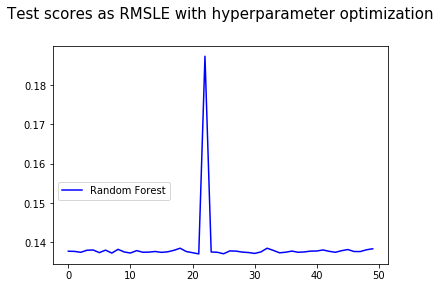

In [5]:
plt.figure()

rf, = plt.plot(RF_scores, color='b')

plt.legend([rf],
           ["Random Forest"],
           bbox_to_anchor=(0, .4, .5, 0))

plt.title('Test scores as RMSLE with hyperparameter optimization',
          x=.5, y=1.1, fontsize="15")

In [6]:
print(RF_scores)
print('Random Forest generalization score: {0}'.format(np.mean(RF_scores)))

[0.13776257350306176, 0.13771936883560157, 0.13748449992886144, 0.13801303330088446, 0.1380739891941768, 0.13740326228581137, 0.13804475950328707, 0.13728544572517265, 0.1382407880208539, 0.13757193585815183, 0.1373049460526052, 0.13791689063380574, 0.1374978277611055, 0.1375402207481577, 0.13769138732871372, 0.13747128829598093, 0.1376112414052873, 0.13799079409170906, 0.13852738377144166, 0.13767782781143456, 0.1373861097048895, 0.13707683006881313, 0.18735659026808563, 0.13757309165505477, 0.13748971011470093, 0.13711503075485557, 0.13784232216885978, 0.1377910037882626, 0.1375360204743105, 0.1374268223875875, 0.13720804344001944, 0.13757565494341878, 0.1385250262288632, 0.13797544604380674, 0.13736033084921337, 0.13750770183572109, 0.13780252287091516, 0.13749111156408006, 0.1375801076503924, 0.1377876782115695, 0.1378149195242614, 0.13808687315326848, 0.13773408870285855, 0.1374885900275835, 0.13790078220249294, 0.13819065639820635, 0.13768789739698498, 0.13767690772715557, 0.1381